In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation, datasets, linear_model
from sklearn.learning_curve import validation_curve
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [55]:
diabetes = datasets.load_diabetes()
print(diabetes.data.shape)

X_train = diabetes.data[:300]
y_train = diabetes.target[:300]
X_test = diabetes.data[300:-1]
y_test = diabetes.target[300:-1]

(442, 10)


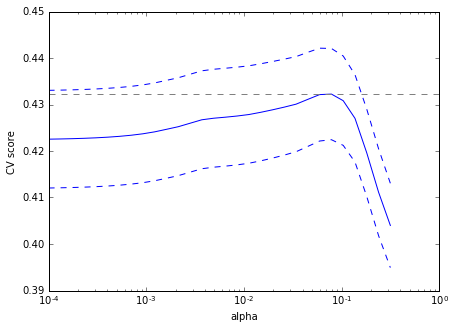

In [56]:
lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X_train, y_train, 
                                                   cv=10, n_jobs=1) # each of size 1xk, k is #folds
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    
plt.figure(figsize=(7, 5))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X_train)), 'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X_train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')

In [84]:
# Fit regression model
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5, 
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3,1e4,1e5], "gamma": np.logspace(-2, 2, 5)})
svr.fit(X_train, y_train)

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})
kr.fit(X_train, y_train)
print(svr.best_estimator_)
print(kr.best_estimator_)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=1.0, kernel='rbf',
      kernel_params=None)


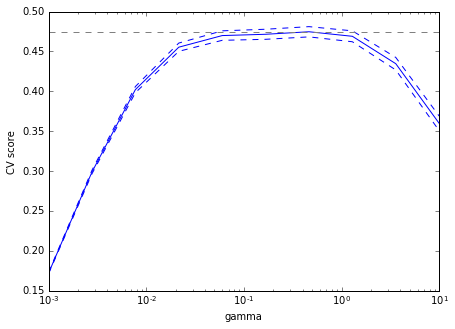

In [92]:
kreg = KernelRidge(kernel='rbf', alpha=kr.best_estimator_.alpha)
gammas = np.logspace(-3, 1, 10)

scores = list()
scores_std = list()

for gamma in gammas:
    kreg.gamma = gamma
    this_scores = cross_validation.cross_val_score(kreg, X_train, y_train, 
                                                   cv=5, n_jobs=1) # each of size 1xk, k is #folds
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    
plt.figure(figsize=(7, 5))
plt.semilogx(gammas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(gammas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X_train)), 'b--')
plt.semilogx(gammas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X_train)), 'b--')
plt.ylabel('CV score')
plt.xlabel('gamma')
plt.axhline(np.max(scores), linestyle='--', color='.5')

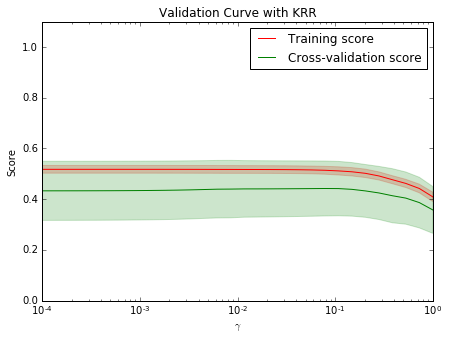

In [71]:
param_range=np.logspace(-4, 0, 30)
train_scores, test_scores = validation_curve(linear_model.Lasso(fit_intercept=True, normalize=True), 
                                             X_train, y_train, param_name="alpha", param_range=param_range, cv=6, n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7, 5))
plt.title("Validation Curve with KRR")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

### How much can you trust the selection of alpha?
To answer this question we use the LassoCV object that sets its alpha parameter automatically from the data by internal cross-validation (i.e. it performs cross-validation on the training data it receives). We use external cross-validation to see how much the automatically obtained alphas differ across different cross-validation folds.

In [73]:
lasso_cv = linear_model.LassoCV(alphas=alphas)
k_fold = cross_validation.KFold(len(X), 3)

print("Answer to the bonus question: how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different subsets of the data:")
for k, (train, test) in enumerate(k_fold):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}". format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))
print()
print("Answer: Not very much since we obtained different alphas for different subsets of the data and moreover,")
print("the scores for these alphas differ quite substantially.")

plt.show()

Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximising the generalization score on different subsets of the data:
[fold 0] alpha: 0.10405, score: 0.53573
[fold 1] alpha: 0.05968, score: 0.16278
[fold 2] alpha: 0.10405, score: 0.44437

Answer: Not very much since we obtained different alphas for different subsets of the data and moreover,
the scores for these alphas differ quite substantially.
